# Visualizing LAPOP data

This follows on the read.py text file which has all the code for cleaning the data and getting it to a point where it can start to be visualized and explored

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pywaffle import Waffle
import prep as pr

import importlib
importlib.reload(pr)

sns.set(rc={'figure.figsize':(13.5,10)})

ModuleNotFoundError: spec not found for the module 'prep'

In [45]:
df = pd.read_csv('Data/clean.csv')
df.head()

,pais,wave,year,idnum,estratopri,estratosec,strata,upm,prov,municipio,...,ros4,sd2new2,sd6new2,sex,sexi,sgl1,soct2,vb2,vb10,vic1ext
0,Guatemala,2012,2012,1296.0,205,2.0,61,1705.0,Petén,201705.0,...,4.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0
1,Guatemala,2012,2012,827.0,206,3.0,65,1006.0,Suchitepéquez,201006.0,...,7.0,2.0,3.0,2.0,2.0,3.0,3.0,1.0,2.0,2.0
2,Guatemala,2012,2012,297.0,201,1.0,37,115.0,Guatemala,200115.0,...,7.0,3.0,3.0,1.0,1.0,3.0,2.0,1.0,2.0,2.0
3,Guatemala,2012,2012,369.0,201,2.0,37,117.0,Guatemala,200117.0,...,7.0,3.0,3.0,1.0,1.0,2.0,2.0,1.0,2.0,2.0
4,Guatemala,2012,2012,1415.0,206,3.0,65,2102.0,Jalapa,202102.0,...,6.0,2.0,2.0,2.0,1.0,2.0,3.0,2.0,1.0,2.0


### What is the distribution of intent to migrate across all three countries over the years in the sample (2012-2019)

Trying to figure out how the intent to migrate has changed per country over time, as well as map out differences between the countries. I will do it as a percentage of the sample, using a heatmap. 

The first step is to select the right columns that I need, which in this case is just year, country, intent to migrate, and weights (since I'm comparing across countries). I'll run the file I've created

In [46]:
cols = ['wave', 'pais', 'weight1500', 'q14']
subs = pr.read_subset(df, cols)
subs.head()

,wave,pais,weight1500,q14
0,2012,Guatemala,0.994036,2.0
1,2012,Guatemala,0.994036,2.0
2,2012,Guatemala,0.994036,2.0
3,2012,Guatemala,0.994036,2.0
4,2012,Guatemala,0.994036,2.0


Now that I've selected the relevant columns, I need to get the total counts in order to start calculating averages

In [47]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,sumvar
0,2012,El Salvador,1.002004,2.0,1132
1,2012,El Salvador,1.002004,1.0,348
2,2012,Guatemala,0.994036,2.0,1270
3,2012,Guatemala,0.994036,1.0,214
4,2012,Honduras,0.495927,2.0,16


Now to apply weights

In [48]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,q14,weighted
0,2012,El Salvador,1.0,348.697392
1,2012,El Salvador,2.0,1134.268528
2,2012,Guatemala,1.0,212.723661
3,2012,Guatemala,2.0,1262.425466
4,2012,Honduras,1.0,164.387886


Now that I've applied the weights, now I need to get percentages. According to LAPOP, the weights are to get to 1500. So that's the division to do here

In [49]:
wts['perc'] = (wts['weighted'] / 1500) * 100
wts.head()

,wave,pais,q14,weighted,perc
0,2012,El Salvador,1.0,348.697392,23.246493
1,2012,El Salvador,2.0,1134.268528,75.617902
2,2012,Guatemala,1.0,212.723661,14.181577
3,2012,Guatemala,2.0,1262.425466,84.161698
4,2012,Honduras,1.0,164.387886,10.959192


Now I'm taking just the 'yes' answers and pivoting in order to produce a heatmap

In [50]:
# take only the 'yes' answers and pivot
mig_final = wts.loc[wts['q14'] == 1.0][['wave', 'pais', 'perc']]
mig_final = mig_final.rename(columns = {'pais': 'country', 'wave':'year'})
mig_final = mig_final.pivot('country', 'year', 'perc')

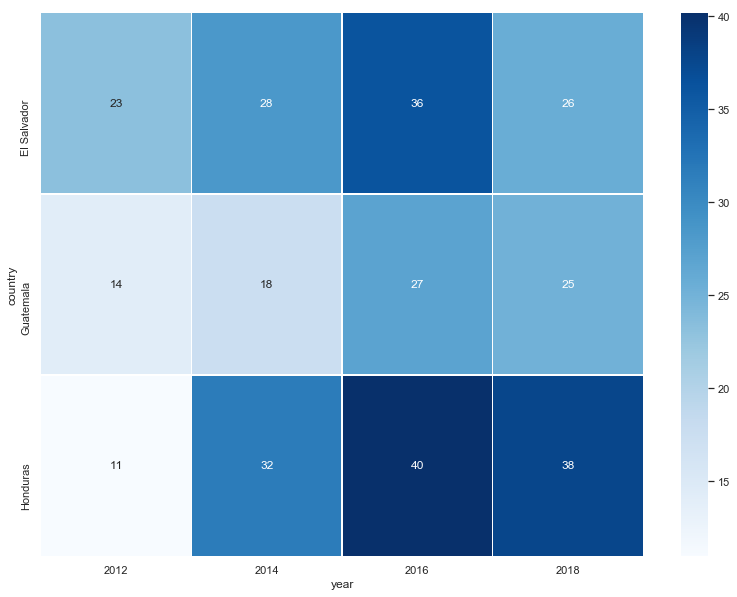

In [51]:
x = sns.heatmap(mig_final, annot=True, cmap="Blues", linewidths = 0.25)#, cbar = False)

This graph shows that, over time, the intent to migrate in these four countries has increased -- albeit with important decreases in 2018. Of the three countries, it's notable that there is a substantial increase in Honduras from 11% in 2012 to 40% in 2016. 

I will export the dataframe to a csv to the visualize in R.

### What's the geographic distribution of intent to migrate at the department level?

Attempting to figure out the geographic distribution of the intent to migrate per department for each country. In order to do so, I will loop through a list of countries, do the relevant group by to get the total of folks who intent to migrate and who don't, find the percentage of those who do per department, and plot.

In [52]:
countries = ['El Salvador', 'Guatemala', 'Honduras']
cols = ['wave', 'prov', 'pais', 'q14']
country_df = []

for c in countries: 
    cdf = pr.country_df(df, cols, c)
    gdf = pr.group_by(cdf, cols)
    total = pr.total(gdf, cols, 'sumvar', False)
    geo_final = total.loc[total['q14'] == 1.0][['wave', 'prov', 'perc_mig']]
    geo_final = geo_final.rename(columns = {'prov': 'state', 'wave':'year'})
    country_df.append(geo_final)

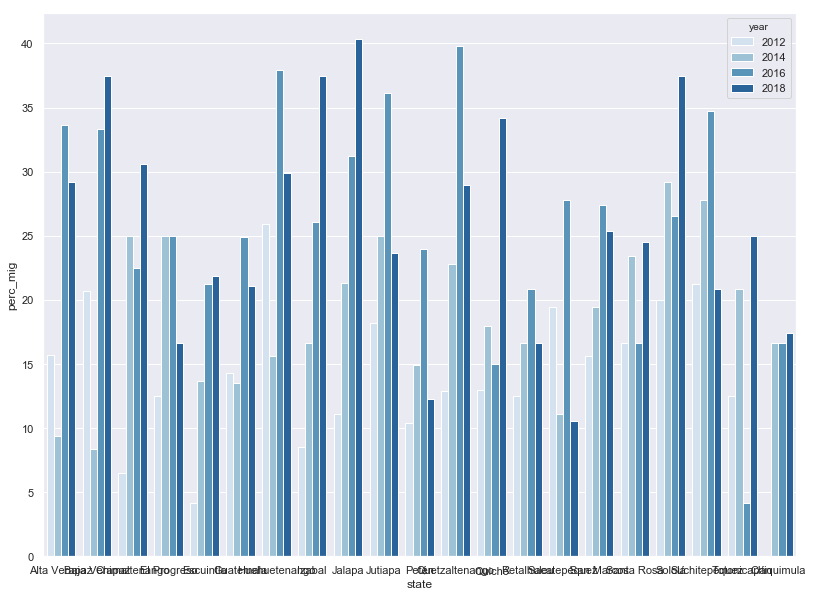

In [53]:
ax = sns.barplot(x="state", y="perc_mig", hue="year", data=country_df[1], palette = "Blues")

Frankly, this is better served as a map with a different metric. It'll be interesting to see some sort of geographic outcome. Maybe a better bet would be to map differences in intent to migrate over the years. Will export to a csv file

### Do people who receive remittances intend to migrate more frequently than those who don't (q10a)?

This is an interesting metric, in that it could either show that people who receive remittances migrate more frequently than those who don't (to be with family presumably), or don't because remittances are useful economically. There could be interesting follow-ons here that could help measure the economic state of families who receive remittances.  

This is a different approach than above, namely because I need to get remittances from folks who intend to migrate, and then sum across the data. I'll then compare those figures to the percentage of people who don't intent to migrate who get remittances. 

First, I'll do those who do intend to migrate.

Let's first find the relevant columns of those who intend to migrate

In [54]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'q10a']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,q10a
10,2012,Guatemala,0.994036,1.0,1.0
17,2012,Guatemala,0.994036,1.0,2.0
33,2012,Guatemala,0.994036,1.0,2.0
37,2012,Guatemala,0.994036,1.0,2.0
40,2012,Guatemala,0.994036,1.0,2.0


Next I need to group by in order to get the total counts of remittance data for those who intend to migrate

In [55]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,q10a,sumvar
0,2012,El Salvador,1.002004,1.0,2.0,237
1,2012,El Salvador,1.002004,1.0,1.0,109
2,2012,El Salvador,1.002004,1.0,0.0,2
3,2012,Guatemala,0.994036,1.0,2.0,165
4,2012,Guatemala,0.994036,1.0,1.0,49


Apply all the weights to get the appropriate totals

In [56]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,q10a,weighted
0,2012,El Salvador,0.0,2.004008
1,2012,El Salvador,1.0,109.218436
2,2012,El Salvador,2.0,237.474948
3,2012,Guatemala,1.0,48.707754
4,2012,Guatemala,2.0,164.015907


Now I calculate percentages of those who receive remittances and intend to migrate

In [57]:
total = pr.total(wts, cols, 'weighted', True)
# pull out just those who receive remittances
intend = total.loc[total['q10a'] == 1.0]
intend.head()

,wave,pais,q10a,weighted,total_mig,perc_mig
1,2012,El Salvador,1.0,109.218436,348.697392,31.321839
3,2012,Guatemala,1.0,48.707754,212.723661,22.897196
6,2012,Honduras,1.0,57.066774,164.387886,34.714707
9,2014,El Salvador,1.0,132.936504,425.595224,31.235431
11,2014,Guatemala,1.0,23.904383,262.948216,9.090909


Now I shall do those who don't intend to migrate following the exact same steps, except for selecting a different value for 'q14'

In [58]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'q10a']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 2.0]

group = pr.group_by(subs, cols)

wts = pr.wts(group, cols, None)

total = pr.total(wts, cols, 'weighted', True)
# pull out just those who receive remittances
nointend = total.loc[total['q10a'] == 1.0]
nointend.head()

,wave,pais,q10a,weighted,total_mig,perc_mig
1,2012,El Salvador,1.0,216.432864,1134.268528,19.081272
4,2012,Guatemala,1.0,91.451294,1262.425466,7.244094
7,2012,Honduras,1.0,129.866496,1279.789036,10.147492
10,2014,El Salvador,1.0,172.619042,1070.436473,16.126043
13,2014,Guatemala,1.0,57.768926,1232.071755,4.688763


Now to merge the two dataframes and calculate the difference between those who intend to migrate and those who don't, and whether they receive remittances

In [59]:
final = intend.merge(nointend, on=['wave', 'pais'])[['wave', 'pais', 'perc_mig_x', 'perc_mig_y']]
final['diff'] = final.perc_mig_x - final.perc_mig_y
final.head()

,wave,pais,perc_mig_x,perc_mig_y,diff
0,2012,El Salvador,31.321839,19.081272,12.240567
1,2012,Guatemala,22.897196,7.244094,15.653102
2,2012,Honduras,34.714707,10.147492,24.567215
3,2014,El Salvador,31.235431,16.126043,15.109389
4,2014,Guatemala,9.090909,4.688763,4.402146


This is intersting as a lollipop mapping differences. It's clear that there's not much of a time component, but there is a component that shows that people who receive remittances are more likely to emigrate than those who don't. 

### What size of cities do people who intend to migrate come from (estratosec)? 

The idea is to understand if people are seeking to migrate more and more from rural areas rather than urban areas. 

As always, my first step is selecting the right columns and keep those who intend to migrate

In [60]:
cols = ['wave', 'pais', 'q14', 'weight1500', 'tamano']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]

subs.head()

,wave,pais,q14,weight1500,tamano
10,2012,Guatemala,1.0,0.994036,4.0
17,2012,Guatemala,1.0,0.994036,5.0
33,2012,Guatemala,1.0,0.994036,5.0
37,2012,Guatemala,1.0,0.994036,1.0
40,2012,Guatemala,1.0,0.994036,4.0


Group by to get the totals of everything

In [61]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,q14,weight1500,tamano,sumvar
0,2012,El Salvador,1.0,1.002004,1.0,126
1,2012,El Salvador,1.0,1.002004,5.0,110
2,2012,El Salvador,1.0,1.002004,3.0,66
3,2012,El Salvador,1.0,1.002004,4.0,27
4,2012,El Salvador,1.0,1.002004,2.0,19


Take the weights since you're comparing across countries

In [62]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,tamano,weighted
0,2012,El Salvador,1.0,126.252504
1,2012,El Salvador,2.0,19.038076
2,2012,El Salvador,3.0,66.132264
3,2012,El Salvador,4.0,27.054108
4,2012,El Salvador,5.0,110.220440


Find the total of folks who emigrated and which size of cities they come from

In [63]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,tamano,weighted,total_mig,perc_mig
0,2012,El Salvador,1.0,126.252504,348.697392,36.206897
1,2012,El Salvador,2.0,19.038076,348.697392,5.459770
2,2012,El Salvador,3.0,66.132264,348.697392,18.965517
3,2012,El Salvador,4.0,27.054108,348.697392,7.758621
4,2012,El Salvador,5.0,110.220440,348.697392,31.609195


I'm going to try to do this as a waffle plot for each country for one year, so I'll do a loop to get datasets for each year 

In [64]:
years = [2012, 2014, 2016, 2018]
waffle = []

for y in years:
    y_tot = total.loc[total['wave'] == y]
    y_tot = y_tot.replace({1.0: 'Capital', 2.0: 'Big City', 3.0: 'Medium City', 4.0: 'Small City', 5.0: 'Rural Area'})
    final = y_tot.pivot('pais', 'tamano', 'perc_mig')
    final = final.swapaxes('index', 'columns')
    waffle.append(final)

waffle[2].head()

pais,El Salvador,Guatemala,Honduras
tamano,,,
Big City,7.857143,4.066986,14.035088
Capital,33.392857,21.052632,8.293461
Medium City,20.357143,5.502392,20.733652
Rural Area,31.071429,53.827751,43.381180
Small City,7.321429,15.550239,13.556619


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


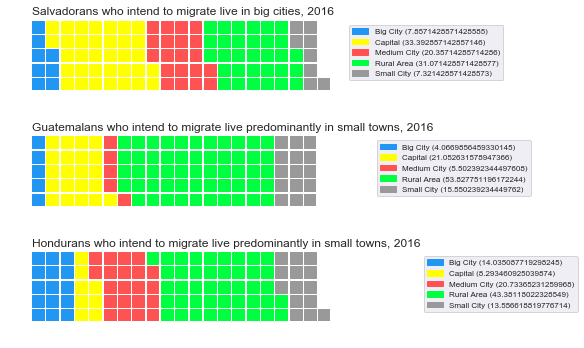

In [65]:
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        '311': {
            'values': waffle[2]['El Salvador'],
            'labels': ["{0} ({1})".format(n, v) for n, v in waffle[2]['El Salvador'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.05, 1), 'fontsize': 8},
            'title': {'label': 'Salvadorans who intend to migrate live in big cities, 2016', 'loc': 'left'}
        },
        '312': {
            'values': waffle[2]['Guatemala'],
            'labels': ["{0} ({1})".format(n, v) for n, v in waffle[2]['Guatemala'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.2, 1), 'fontsize': 8},
            'title': {'label': 'Guatemalans who intend to migrate live predominantly in small towns, 2016', 'loc': 'left'}
        },
        '313': {
            'values': waffle[2]['Honduras'],
            'labels': ["{0} ({1})".format(n, v) for n, v in waffle[2]['Honduras'].items()],
            'legend': {'loc': 'upper left', 'bbox_to_anchor': (1.3, 1), 'fontsize': 8},
            'title': {'label': 'Hondurans who intend to migrate live predominantly in small towns, 2016', 'loc': 'left'}
        },
    },
    rows=5,
    colors=("#2196f3", "#ffff00", "#ff5252", "#00ff40", "#999999"),  # Default argument values for subplots
    figsize=(9, 5)  # figsize is a parameter of plt.figure
)

### Age and sex of those who intend to migrate (q1 and q2)?

Certainly expect to find that younger males are more likely to intend to emigrate than females of any age, but I'll be looking principally at whether or not this trend holds over time as more and more women are making the trek. 

I want to do a line graph or a slope graph, with blue for men and pink for women. Different shades will differentiate age groups. 

Let me first select the right columns, but also those who intend to migrate as well as create age groups

In [66]:
cols = ['wave', 'pais', 'q14', 'q1','weight1500', 'q2']

subs = pr.read_subset(df, cols)
bins = pd.IntervalIndex.from_tuples([(0, 17), (18, 35), (36, 50), (51,65), (66,100)])
subs['q2'] =  pd.cut(subs['q2'], bins, labels = ['0-17', '18-35', '36-50', '51-65', '66+'])
subs = subs.loc[subs['q14'] == 1.0]

subs.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,wave,pais,q14,q1,weight1500,q2
10,2012,Guatemala,1.0,1.0,0.994036,"(18, 35]"
17,2012,Guatemala,1.0,1.0,0.994036,"(18, 35]"
33,2012,Guatemala,1.0,1.0,0.994036,NaN
37,2012,Guatemala,1.0,1.0,0.994036,"(18, 35]"
40,2012,Guatemala,1.0,1.0,0.994036,"(36, 50]"


Moving right along to get the totals through grouping

In [67]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,q14,q1,weight1500,q2,sumvar
0,2012,El Salvador,1.0,1.0,1.002004,"(18, 35]",126
1,2012,El Salvador,1.0,1.0,1.002004,"(36, 50]",37
2,2012,El Salvador,1.0,1.0,1.002004,"(51, 65]",11
3,2012,El Salvador,1.0,1.0,1.002004,"(66, 100]",10
4,2012,El Salvador,1.0,2.0,1.002004,"(18, 35]",84


Apply the weights I need here

In [68]:
wts = pr.wts(group, cols, 'q1')
wts.head()

,wave,pais,q1,q2,weighted
0,2012,El Salvador,1.0,"(18, 35]",126.252504
1,2012,El Salvador,1.0,"(36, 50]",37.074148
2,2012,El Salvador,1.0,"(51, 65]",11.022044
3,2012,El Salvador,1.0,"(66, 100]",10.020040
4,2012,El Salvador,2.0,"(18, 35]",84.168336


Let's find the totals per age 

In [69]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,q1,q2,weighted,total_mig,perc_mig
0,2012,El Salvador,1.0,"(18, 35]",126.252504,309.619236,40.776699
1,2012,El Salvador,1.0,"(36, 50]",37.074148,309.619236,11.974110
2,2012,El Salvador,1.0,"(51, 65]",11.022044,309.619236,3.559871
3,2012,El Salvador,1.0,"(66, 100]",10.020040,309.619236,3.236246
4,2012,El Salvador,2.0,"(18, 35]",84.168336,309.619236,27.184466


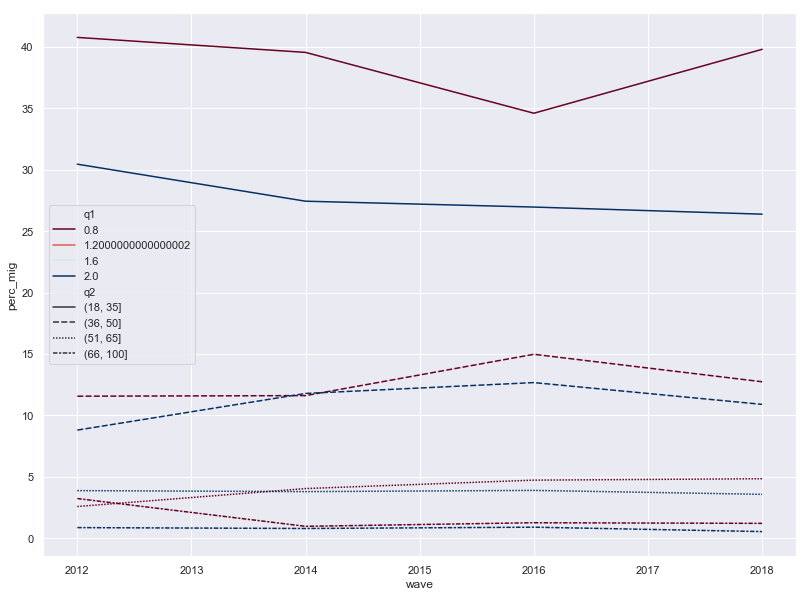

In [70]:
ax = sns.lineplot(x="wave", y="perc_mig",
                  hue="q1", style="q2",palette='RdBu', ci=None,
                  data=total)

### Safety in neighborhood and intent to migrate (aoj11)?

Here we're trying to find how being a victim of assault or robbery influences the decision to migrate. There's two ways to make the case -- one is measuring the difference between those who intend to migrate and those who don't in their victimization; the other is to compare it to other possible reasons (corruption, poverty, trust in institutions). 

In this scenario, we'll take a look at the difference between the two. First by looking at those who intend to migrate, and the rate at which they report that they feel very secure, somewhat secure, somewhat insecure, or very insecure in their neighborhoods. 

In [71]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'aoj11']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,aoj11
10,2012,Guatemala,0.994036,1.0,2.0
17,2012,Guatemala,0.994036,1.0,1.0
33,2012,Guatemala,0.994036,1.0,1.0
37,2012,Guatemala,0.994036,1.0,3.0
40,2012,Guatemala,0.994036,1.0,2.0


In [72]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,aoj11,sumvar
0,2012,El Salvador,1.002004,1.0,2.0,124
1,2012,El Salvador,1.002004,1.0,3.0,110
2,2012,El Salvador,1.002004,1.0,1.0,68
3,2012,El Salvador,1.002004,1.0,4.0,43
4,2012,El Salvador,1.002004,1.0,0.0,3


In [73]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,aoj11,weighted
0,2012,El Salvador,0.0,3.006012
1,2012,El Salvador,1.0,68.136272
2,2012,El Salvador,2.0,124.248496
3,2012,El Salvador,3.0,110.220440
4,2012,El Salvador,4.0,43.086172


In [74]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,aoj11,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,3.006012,348.697392,0.862069
1,2012,El Salvador,1.0,68.136272,348.697392,19.540230
2,2012,El Salvador,2.0,124.248496,348.697392,35.632184
3,2012,El Salvador,3.0,110.220440,348.697392,31.609195
4,2012,El Salvador,4.0,43.086172,348.697392,12.356322


### Does having confidence in the efficacy justice instituions relate to intent to migrate (aoj12)?

This questions asks: If you were the victim of an assault or robbery, how much confidence would you have that the judicial system would capture the person(s) responsible?

1: A lot
2: Some
3: Little
4: None

In [75]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'aoj12']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,aoj12
10,2012,Guatemala,0.994036,1.0,2.0
17,2012,Guatemala,0.994036,1.0,1.0
33,2012,Guatemala,0.994036,1.0,4.0
37,2012,Guatemala,0.994036,1.0,3.0
40,2012,Guatemala,0.994036,1.0,2.0


In [76]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,aoj12,sumvar
0,2012,El Salvador,1.002004,1.0,4.0,103
1,2012,El Salvador,1.002004,1.0,1.0,87
2,2012,El Salvador,1.002004,1.0,3.0,82
3,2012,El Salvador,1.002004,1.0,2.0,71
4,2012,El Salvador,1.002004,1.0,0.0,5


In [77]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,aoj12,weighted
0,2012,El Salvador,0.0,5.010020
1,2012,El Salvador,1.0,87.174348
2,2012,El Salvador,2.0,71.142284
3,2012,El Salvador,3.0,82.164328
4,2012,El Salvador,4.0,103.206412


In [78]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,aoj12,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,5.010020,348.697392,1.436782
1,2012,El Salvador,1.0,87.174348,348.697392,25.000000
2,2012,El Salvador,2.0,71.142284,348.697392,20.402299
3,2012,El Salvador,3.0,82.164328,348.697392,23.563218
4,2012,El Salvador,4.0,103.206412,348.697392,29.597701


## Has an agent of the police bribed you (exc2), or a public official bribed you (exc6) 

I'll start with agents of the police, wondering at the moment if I should combine the two or not. Obviously pulling out those who replied that they intend to migrate 

In [79]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'exc2']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,exc2
10,2012,Guatemala,0.994036,1.0,0.0
17,2012,Guatemala,0.994036,1.0,0.0
33,2012,Guatemala,0.994036,1.0,0.0
37,2012,Guatemala,0.994036,1.0,0.0
40,2012,Guatemala,0.994036,1.0,0.0


In [80]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,exc2,sumvar
0,2012,El Salvador,1.002004,1.0,0.0,311
1,2012,El Salvador,1.002004,1.0,1.0,37
2,2012,Guatemala,0.994036,1.0,0.0,164
3,2012,Guatemala,0.994036,1.0,1.0,50
4,2012,Honduras,0.495927,1.0,0.0,1


In [81]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,exc2,weighted
0,2012,El Salvador,0.0,311.623244
1,2012,El Salvador,1.0,37.074148
2,2012,Guatemala,0.0,163.021871
3,2012,Guatemala,1.0,49.701790
4,2012,Honduras,0.0,126.644578


In [82]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,exc2,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,311.623244,348.697392,89.367816
1,2012,El Salvador,1.0,37.074148,348.697392,10.632184
2,2012,Guatemala,0.0,163.021871,212.723661,76.635514
3,2012,Guatemala,1.0,49.701790,212.723661,23.364486
4,2012,Honduras,0.0,126.644578,164.387886,77.040091


Moving on to folks who have been bribed by any public official

In [83]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'exc6']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,exc6
10,2012,Guatemala,0.994036,1.0,0.0
17,2012,Guatemala,0.994036,1.0,0.0
33,2012,Guatemala,0.994036,1.0,0.0
37,2012,Guatemala,0.994036,1.0,0.0
40,2012,Guatemala,0.994036,1.0,0.0


In [84]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,exc6,sumvar
0,2012,El Salvador,1.002004,1.0,0.0,334
1,2012,El Salvador,1.002004,1.0,1.0,14
2,2012,Guatemala,0.994036,1.0,0.0,197
3,2012,Guatemala,0.994036,1.0,1.0,17
4,2012,Honduras,0.495927,1.0,0.0,1


In [85]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,exc6,weighted
0,2012,El Salvador,0.0,334.669336
1,2012,El Salvador,1.0,14.028056
2,2012,Guatemala,0.0,195.825053
3,2012,Guatemala,1.0,16.898609
4,2012,Honduras,0.0,141.318431


In [86]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,exc6,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,334.669336,348.697392,95.977011
1,2012,El Salvador,1.0,14.028056,348.697392,4.022989
2,2012,Guatemala,0.0,195.825053,212.723661,92.056075
3,2012,Guatemala,1.0,16.898609,212.723661,7.943925
4,2012,Honduras,0.0,141.318431,164.387886,85.966451


I'm not sure that independently these make a lot of impact, so maybe it's worth bringing them together. 

## Have you participated in a public demonstration in the last 12 months (prot3)

In [87]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'prot3']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,prot3
10,2012,Guatemala,0.994036,1.0,2.0
17,2012,Guatemala,0.994036,1.0,2.0
33,2012,Guatemala,0.994036,1.0,1.0
37,2012,Guatemala,0.994036,1.0,2.0
40,2012,Guatemala,0.994036,1.0,2.0


In [88]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,prot3,sumvar
0,2012,El Salvador,1.002004,1.0,2.0,328
1,2012,El Salvador,1.002004,1.0,1.0,20
2,2012,Guatemala,0.994036,1.0,2.0,185
3,2012,Guatemala,0.994036,1.0,1.0,26
4,2012,Guatemala,0.994036,1.0,0.0,3


In [89]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,prot3,weighted
0,2012,El Salvador,1.0,20.040080
1,2012,El Salvador,2.0,328.657312
2,2012,Guatemala,0.0,2.982107
3,2012,Guatemala,1.0,25.844931
4,2012,Guatemala,2.0,183.896623


In [90]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,prot3,weighted,total_mig,perc_mig
0,2012,El Salvador,1.0,20.040080,348.697392,5.747126
1,2012,El Salvador,2.0,328.657312,348.697392,94.252874
2,2012,Guatemala,0.0,2.982107,212.723661,1.401869
3,2012,Guatemala,1.0,25.844931,212.723661,12.149533
4,2012,Guatemala,2.0,183.896623,212.723661,86.448598


## Does your household income cover all your expenses (q10d) 

(1) Les alcanza bien y pueden ahorrar
(2) Les alcanza justo sin grandes dificultades
(3) No les alcanza y tienen dificultades
(4) No les alcanza y tienen grandes dificultades 

In [91]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'q10d']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,q10d
10,2012,Guatemala,0.994036,1.0,3.0
17,2012,Guatemala,0.994036,1.0,3.0
33,2012,Guatemala,0.994036,1.0,3.0
37,2012,Guatemala,0.994036,1.0,3.0
40,2012,Guatemala,0.994036,1.0,3.0


In [92]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,q10d,sumvar
0,2012,El Salvador,1.002004,1.0,2.0,131
1,2012,El Salvador,1.002004,1.0,3.0,118
2,2012,El Salvador,1.002004,1.0,4.0,78
3,2012,El Salvador,1.002004,1.0,1.0,16
4,2012,El Salvador,1.002004,1.0,0.0,5


In [93]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,q10d,weighted
0,2012,El Salvador,0.0,5.010020
1,2012,El Salvador,1.0,16.032064
2,2012,El Salvador,2.0,131.262524
3,2012,El Salvador,3.0,118.236472
4,2012,El Salvador,4.0,78.156312


In [94]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,q10d,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,5.010020,348.697392,1.436782
1,2012,El Salvador,1.0,16.032064,348.697392,4.597701
2,2012,El Salvador,2.0,131.262524,348.697392,37.643678
3,2012,El Salvador,3.0,118.236472,348.697392,33.908046
4,2012,El Salvador,4.0,78.156312,348.697392,22.413793


## Have you been the victim of crime in the last 12 months (vic1ext) 

1) Yes
2) No

In [95]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'vic1ext']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,vic1ext
10,2012,Guatemala,0.994036,1.0,2.0
17,2012,Guatemala,0.994036,1.0,2.0
33,2012,Guatemala,0.994036,1.0,2.0
37,2012,Guatemala,0.994036,1.0,1.0
40,2012,Guatemala,0.994036,1.0,2.0


In [96]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,vic1ext,sumvar
0,2012,El Salvador,1.002004,1.0,2.0,259
1,2012,El Salvador,1.002004,1.0,1.0,89
2,2012,Guatemala,0.994036,1.0,2.0,145
3,2012,Guatemala,0.994036,1.0,1.0,69
4,2012,Honduras,0.495927,1.0,2.0,1


In [97]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,vic1ext,weighted
0,2012,El Salvador,1.0,89.178356
1,2012,El Salvador,2.0,259.519036
2,2012,Guatemala,1.0,68.588470
3,2012,Guatemala,2.0,144.135191
4,2012,Honduras,0.0,0.760834


In [100]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,vic1ext,weighted,total_mig,perc_mig
0,2012,El Salvador,1.0,89.178356,348.697392,25.574713
1,2012,El Salvador,2.0,259.519036,348.697392,74.425287
2,2012,Guatemala,1.0,68.588470,212.723661,32.242991
3,2012,Guatemala,2.0,144.135191,212.723661,67.757009
4,2012,Honduras,0.0,0.760834,164.387886,0.462829


## Would you say local (municipal) services are good (sgl1) 

(1) Muy buenos (2) Buenos (3) Ni buenos ni malos (regulares)
(4) Malos (5) Muy malos (pésimos)

In [101]:
cols = ['wave', 'pais', 'weight1500', 'q14', 'sgl1']
subs = pr.read_subset(df, cols)
subs = subs.loc[subs['q14'] == 1.0]
subs.head()

,wave,pais,weight1500,q14,sgl1
10,2012,Guatemala,0.994036,1.0,3.0
17,2012,Guatemala,0.994036,1.0,2.0
33,2012,Guatemala,0.994036,1.0,3.0
37,2012,Guatemala,0.994036,1.0,3.0
40,2012,Guatemala,0.994036,1.0,3.0


In [102]:
group = pr.group_by(subs, cols)
group.head()

,wave,pais,weight1500,q14,sgl1,sumvar
0,2012,El Salvador,1.002004,1.0,3.0,141
1,2012,El Salvador,1.002004,1.0,2.0,108
2,2012,El Salvador,1.002004,1.0,4.0,64
3,2012,El Salvador,1.002004,1.0,5.0,16
4,2012,El Salvador,1.002004,1.0,1.0,10


In [103]:
wts = pr.wts(group, cols, None)
wts.head()

,wave,pais,sgl1,weighted
0,2012,El Salvador,0.0,9.018036
1,2012,El Salvador,1.0,10.020040
2,2012,El Salvador,2.0,108.216432
3,2012,El Salvador,3.0,141.282564
4,2012,El Salvador,4.0,64.128256


In [104]:
total = pr.total(wts, cols, 'weighted', True)
total.head()

,wave,pais,sgl1,weighted,total_mig,perc_mig
0,2012,El Salvador,0.0,9.018036,348.697392,2.586207
1,2012,El Salvador,1.0,10.020040,348.697392,2.873563
2,2012,El Salvador,2.0,108.216432,348.697392,31.034483
3,2012,El Salvador,3.0,141.282564,348.697392,40.517241
4,2012,El Salvador,4.0,64.128256,348.697392,18.390805


In [43]:
df.columns

Index(['pais', 'wave', 'year', 'idnum', 'estratopri', 'estratosec', 'strata',
       'upm', 'prov', 'municipio', 'cluster', 'ur', 'tamano', 'idiomaq', 'wt',
       'weight1500', 'q1', 'q2', 'aoj11', 'aoj12', 'b1', 'b2', 'b3', 'b4',
       'b6', 'b12', 'b13', 'b18', 'b21', 'b21a', 'b32', 'b47a', 'colori',
       'colorr', 'cp6', 'cp7', 'cp8', 'cp13', 'd1', 'd2', 'd3', 'd4', 'd5',
       'e5', 'ed', 'eff1', 'eff2', 'exc2', 'exc6', 'idio2', 'it1', 'm1',
       'nationality', 'np1', 'ocup4a', 'pol1', 'prot3', 'q5b', 'q5bnr', 'q10a',
       'q10d', 'q10e', 'q12c', 'q14', 'r1', 'r3', 'r4', 'r4a', 'r5', 'r6',
       'r7', 'r8', 'r12', 'r14', 'r15', 'ros4', 'sd2new2', 'sd6new2', 'sex',
       'sexi', 'sgl1', 'soct2', 'vb2', 'vb10', 'vic1ext'],
      dtype='object')